In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
df = pd.read_excel('Мл. аналитик про.xlsx', sheet_name=2)

In [61]:
"""Удаляем лишние строки и столбец, обновляем индексы, переназываем столбцы."""

df = df.drop([0,1])
df = df.reset_index()
df = df.drop(columns=['index'])
df = df.rename(columns={'Отчет за период с 2019-02-11 по 2019-02-17':'Urls', 'Unnamed: 1':'Views'})
df.head(10)

,Urls,Views
0,https://pro.rbc.ru/news/5c4af9ed9a7947bd94fe0cc9,2849
1,http://pro.rbc.ru/news/5c61b2d39a794798b96fab0c,2845
2,https://pro.rbc.ru/news/5c6195799a79478b57ba6cf3,2819
3,https://pro.rbc.ru//news/5c63fbff9a7947481bf4ce1b,2736
4,https://pro.rbc.ru/news/5c46d39b9a7947fc20fbcce6,2704
5,https://pro.rbc.ru/news/5c60c9fd9a794747ed04cfe2,2691
6,https://pro.rbc.ru//news/5c65950d9a79474f82f780d7,2623
7,https://pro.rbc.ru/news/5c5436a39a79472d6c58bca8,2615
8,https://pro.rbc.ru/news/5c658e479a79474d32847233,2589
9,https://pro.rbc.ru/news/5c503adb9a794784a693903b,2588


In [62]:
df.isna().sum()

Urls     0
Views    0
dtype: int64

In [63]:
"""Удалим из списка ссылки, содержащие указанные URL."""

bans = ['test.pro', 'test.v2.pro', 'feature-rbcnews', '/preview/', 'staging.pro', 'staging.v2.pro']

for i in bans:
    df = df[~df.Urls.str.contains(i)]

In [64]:
print(len(df), df['Urls'].nunique()) ## проверяем на повторы ссылок

2465 830


In [65]:
"""Суммируем просмотры повторяющихся ссылок и удаляем дубликаты."""

df['Views'] = df.groupby(['Urls'])['Views'].transform('sum')
df = df.drop_duplicates(subset=['Urls'])

In [66]:
len(df) # проверяем, ничего ли не потеряли

830

In [67]:
df = df.sort_values(by=['Views'], ascending=False) # сортируем
top_20 = df.head(20)

In [68]:
# достаём ID статей
top_20.insert(2, 'Ids', top_20['Urls'].apply(lambda x: pd.Series(x.split('/')[-1])))

In [69]:
df2 = pd.read_excel('Мл. аналитик про.xlsx', sheet_name=1) # выгружаем второй лист с названиями статей
df2 = df2.drop(columns=['URL'])
df2 = df2.rename(columns={'ID публикации':'Ids', 'Заголовок материала':'Article'})
df2.head(5)

,Ids,Article
0,5bf52faf9a79477da426e81b,Как обанкротиться подешевле: прагматичные наст...
1,5c04ee439a7947b3fe48fe55,Имитация тунца: как искусственная рыба вытесня...
2,5c04f06c9a7947b48d48fe60,Сколько россияне тратят на путешествия
3,5c0695d69a79472e0096479e,Самые ходовые: какие специалисты в строительст...
4,5c07891f9a794775e61affd1,Как запустить новый продукт: четыре обязательн...


In [70]:
top_20 = top_20.merge(df2, on='Ids', how='left') # соединяем таблички по Ids
top_20.head(5)

,Urls,Views,Ids,Article
0,https://pro.rbc.ru/news/5c658e479a79474d32847233,11320,5c658e479a79474d32847233,"Глава BlaBlaCar — РБК: «Мы оказывали услуги, н..."
1,https://pro.rbc.ru/news/5c65950d9a79474f82f780d7,7422,5c65950d9a79474f82f780d7,«Алые паруса» сворачиваются: почему владельцы ...
2,https://pro.rbc.ru/news/5c503adb9a794784a693903b,7044,5c503adb9a794784a693903b,Недооцененный экспорт: что имеет смысл продава...
3,https://pro.rbc.ru/news/5c6454df9a794769a732e049,6483,5c6454df9a794769a732e049,Требования работодателя vs ожидания кандидатов...
4,https://pro.rbc.ru/news/5c643a319a794760bbe62974,6325,5c643a319a794760bbe62974,Восемь способов увеличить средний чек


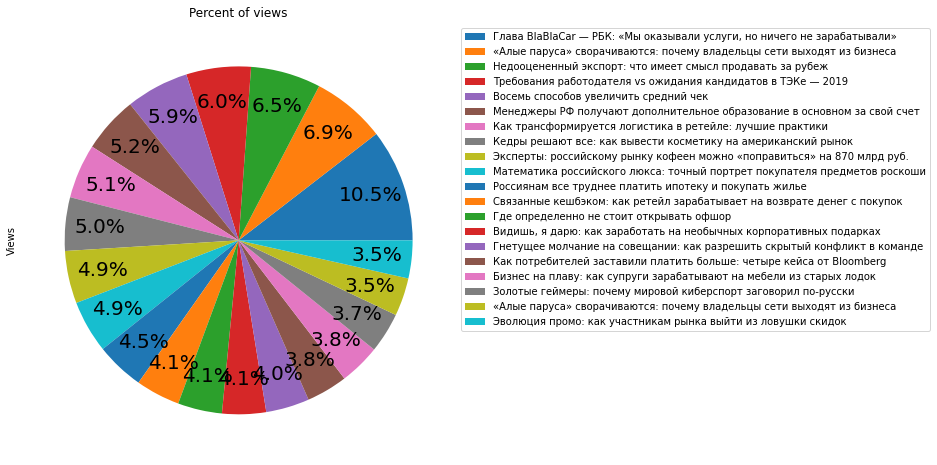

In [71]:
"""Попробуем визуализировать Топ-20 статей по просмотрам."""

top = top_20.set_index('Article')
top = top.drop(columns=['Urls'])
pie = top.plot(y='Views', kind='pie', figsize=(8, 8), autopct='%1.1f%%', title='Percent of views', 
                legend=True, loglog=True, fontsize=20, pctdistance=0.8, labeldistance=None)
pie.legend(bbox_to_anchor=(1, 1))

Text(0.5, 0, 'Amount of views')

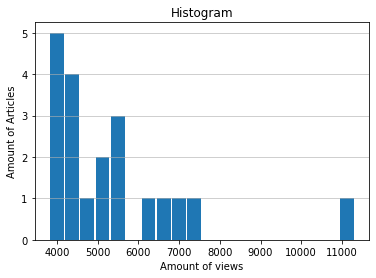

In [72]:
# количество статей по просмотрам

plt.grid(axis='y', alpha=0.75)
plt.hist(top['Views'], bins=20, rwidth=0.9)
plt.title('Histogram')
plt.ylabel('Amount of Articles')
plt.xlabel('Amount of views')

In [73]:
"""Делаем гиперсслыки для Excel."""

def make_hyperlink(lst):
    return '=HYPERLINK("%s", "%s")' % (lst[0], lst[1])

temp = []    
tmp = []

for i in range(len(top_20)):
    temp.append((top_20.iat[i,0], top_20.iat[i,3]))

for i in temp:
    tmp.append(make_hyperlink(i))
    
top_20 = top_20.assign(Article=tmp)

In [74]:
"""Выгружаем в Excel Топ-20 статей по просмотрам в порядке убывания с гиперссылками."""

top_to_excel = top_20.drop(columns=['Urls', 'Ids'])
top_to_excel.to_excel('Топ-20 статей по просмотрам.xlsx')